In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('../data/foot_traffic.csv')
df

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695
...,...
995,706.009031
996,705.610549
997,704.771335
998,703.559920


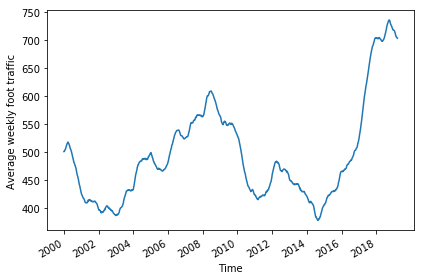

In [3]:
fig, ax = plt.subplots()
ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(df['foot_traffic'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -1.1758885999240802
p-value: 0.6838808917896166


Since the ADF statistic is not a large negative number, and it has a p-value greater than 0.05, we cannot reject the null hypothesis and our series is therefore **non-stationary**

In [5]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

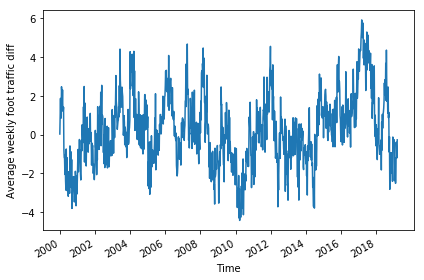

In [6]:
fig, ax = plt.subplots()
ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic diff')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ADF_result = adfuller(foot_traffic_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -5.268231347422038
p-value: 6.3693176547814515e-06


We now have a **stationary series**

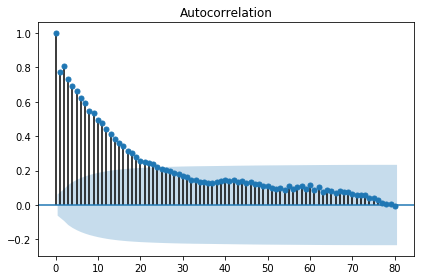

In [8]:
plot_acf(foot_traffic_diff, lags=80);
plt.tight_layout()

There is no lag at which the coefficients abruptly become non-significant. This means that we do not have a moving average process and that we are likely studying an **autoregressive** process.

We must find another way to identify the order p of the AR(p)

### The partial autocorrelation function (PACF)

In [9]:
np.random.seed(42)
ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

In [10]:
type(AR2_process)

numpy.ndarray

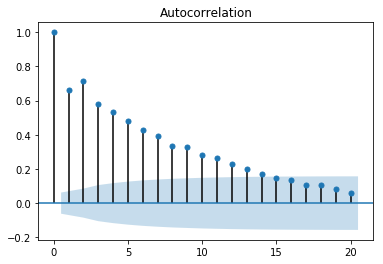

In [11]:
plot_acf(AR2_process, lags=20);

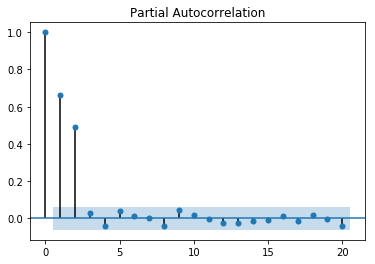

In [12]:
plot_pacf(AR2_process, lags=20);

It shows that we have an autoregressive process of order 2

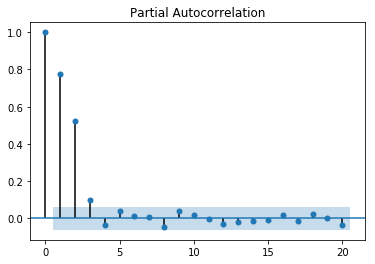

In [13]:
plot_pacf(foot_traffic_diff, lags=20);

There are no significant coefficients after lag 3. Therefore, the differenced average weekly foot traffic is an autoregressive process of
order 3, which can also be denoted as AR(3)

## Forecasting an autoregressive process

In [14]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train = df_diff[:-52]
test = df_diff[-52:]

print(len(train), len(test))

947 52


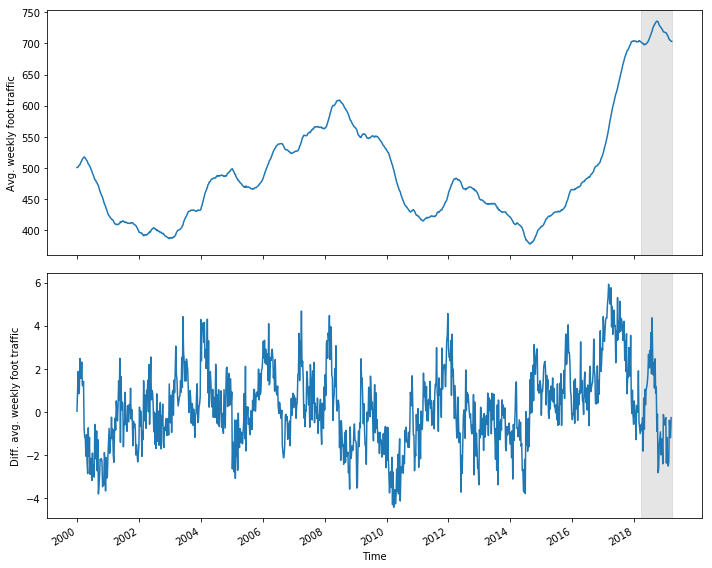

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [16]:
def rolling_forecast(
    df: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: str
) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 0, 0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

In [17]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


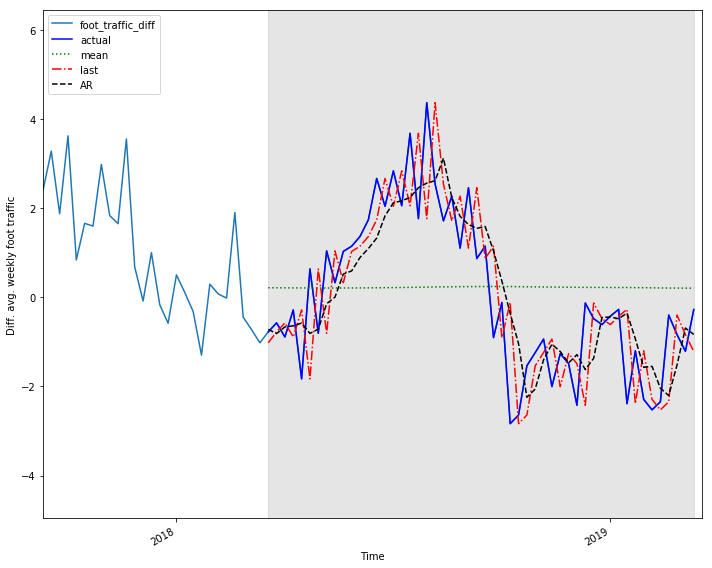

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')
ax.axvspan(947, 998, color='#808080', alpha=0.2)
ax.set_xlim(920, 999)
plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701545 1.4487301184959818 0.9242479168428859


In [20]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


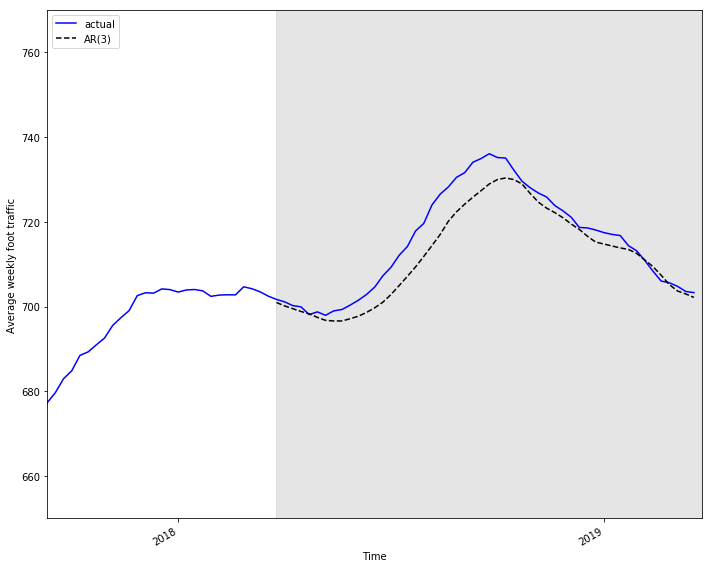

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
ax.axvspan(948, 1000, color='#808080', alpha=0.2)
ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)
plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])
mae_AR_undiff

3.478033559167867